In [2]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
from skimage.io import imsave
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from skimage.util import crop
from skimage.io import imsave, imread
from scipy.ndimage import binary_fill_holes
import time
import random
import traceback


sys.path.append('../src')
import unet7

In [3]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_cols = 1392
img_rows = 1040
model_dir = '../data'
start_lr = 1e-4
target_width = 256
target_height = 256

upscale_factor_width = img_cols / target_width
upscale_factor_height = img_cols / target_height

In [4]:
#Number of minibatches to generate
n_minibatches = 1
#Size of minibatch
minibatch_size = 10
#Percentge of each minibatch that should correspond to foreground object
thresh_obj_perc = 0.25


In [5]:
def checkDir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def read_imgs(dir, img_rows, img_cols):
    images = [f for f in os.listdir(dir) if f.endswith('.tif')]
    imgs = np.ndarray((len(images), img_rows, img_cols, 1), dtype=np.float64)
    for idx, img in enumerate(images):
        #print(idx)
        img = imread(os.path.join(dir, img), as_gray=True)
        img = np.expand_dims(img, axis=-1)
        imgs[idx] = img
    return imgs


def read_imgs_masks_in_patches(img_dir, mask_dir, img_rows, img_cols,
                    target_width=target_width, target_height=target_height,
                    n_minibatches=n_minibatches, minibatch_size=minibatch_size, thresh_obj_perc=thresh_obj_perc):

    random.seed(123)
    images = [f for f in os.listdir(img_dir) if f.endswith('.tif')]

    #creating a dictionary for the paths of img and msk and the enumerated number corresponding to it
    img_msk_dict = {}
    for idx, img in enumerate(images):
        img_msk_dict[idx] = [img]
        msk = img.replace('.tif', '_Simple Segmentation.tif')
        img_msk_dict[idx].append(msk)

    #print(img_msk_dict)

    minibatch_dict = {}
    minibatch_c = 0
    while minibatch_c < n_minibatches: # or trial > max_iter = 50
        # trial = 1
        imgs_minibatch = np.ndarray((minibatch_size, target_height, target_width, 1), dtype=np.float64)
        masks_minibatch = np.ndarray((minibatch_size, target_height, target_width, 1), dtype=np.float64)
        for idx in range(minibatch_size):
            
            #picking a random training image and corresponding from the list
            rand = random.randrange(len(images))
            msk = img_msk_dict[rand][1]
            img = img_msk_dict[rand][0]

            img = imread(os.path.join(img_dir, img), as_gray=True)
            #generating a random patch of img
            rand_x = random.randrange(img.shape[0])
            rand_y = random.randrange(img.shape[1])
            img = img[rand_x : min(rand_x+target_width,img.shape[0]), rand_y : min(rand_y+target_width,img.shape[1])]

            #padding img to fit the network
            pad_x = (target_width - img.shape[0])/2
            pad_y = (target_height - img.shape[1])/2

            if int(pad_x) > pad_x or int(pad_x) < pad_x :
                if int(pad_y) > pad_y or int(pad_y) < pad_y :
                    pad_x1 = int(np.floor(pad_x))
                    pad_x2 = int(np.ceil(pad_x))
                    pad_y1 = int(np.floor(pad_y))
                    pad_y2 = int(np.ceil(pad_y))
                else:
                    pad_x1 = int(np.floor(pad_x))
                    pad_x2 = int(np.ceil(pad_x))
                    pad_y1 = int(pad_y)
                    pad_y2 = int(pad_y)

            else:
                if int(pad_y) > pad_y or int(pad_y) < pad_y :
                    pad_x1 = int(pad_x)
                    pad_x2 = int(pad_x)
                    pad_y1 = int(np.floor(pad_y))
                    pad_y2 = int(np.ceil(pad_y))            
                else:
                    pad_x1 = int(pad_x)
                    pad_x2 = int(pad_x)
                    pad_y1 = int(pad_y)
                    pad_y2 = int(pad_y)
                
            img = np.pad(img, ((pad_x1, pad_x2), (pad_y1, pad_y2)),
                                       mode='constant', constant_values=0)    

            img = np.expand_dims(img, axis=-1)
            imgs_minibatch[idx] = img
            
            mask = imread(os.path.join(mask_dir, msk), as_gray=True)
            #generating the corresponding random patch of msk
            mask = mask[rand_x : min(rand_x+target_width,mask.shape[0]), rand_y : min(rand_y+target_width,mask.shape[1])]

            #padding msk same as img to fit the network
            mask = np.pad(mask, ((pad_x1, pad_x2), (pad_y1, pad_y2)),
                                       mode='constant', constant_values=0) 

            mask = np.expand_dims(mask, axis=-1)
            masks_minibatch[idx] = mask
        

            #count perc of white pixels in bw mask
            mask_bw = np.rint(mask)
            number_of_white_pix = np.sum(mask_bw == 255)      # extracting only white pixels 
            perc_of_white_pix = number_of_white_pix/(mask_bw.shape[0]*mask_bw.shape[1])

            minibatch_dict[idx] = {}
            minibatch_dict[idx]['pad_x1'] = pad_x1 #left
            minibatch_dict[idx]['pad_x2'] = pad_x2 #right
            minibatch_dict[idx]['pad_y1'] = pad_y1 #top
            minibatch_dict[idx]['pad_y2'] = pad_y2 #bottom
            minibatch_dict[idx]['perc_of_white_pix'] = perc_of_white_pix
        
        minibatch_white_pix_perc_l = [minibatch_dict[idx]['perc_of_white_pix'] for idx in range(minibatch_size)]
        if np.mean(minibatch_white_pix_perc_l) >= thresh_obj_perc :
            minibatch_c += 1

        # trial += 1

    return minibatch_dict, imgs_minibatch, masks_minibatch


In [6]:
training_img_dir = os.path.join(model_dir,'train','img')
training_mask_dir = os.path.join(model_dir,'train','mask')
test_img_dir = os.path.join(model_dir,'test','img')
test_mask_dir = os.path.join(model_dir,'test','mask')

In [23]:
# load training images

minibatch_dict, training_imgs, training_masks= read_imgs_masks_in_patches(training_img_dir, training_mask_dir, img_rows, img_cols)

In [24]:
minibatch_dict

{0: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.00726318359375},
 1: {'pad_x1': 52,
  'pad_x2': 52,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 1.52587890625e-05},
 2: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 3: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 4: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0759735107421875},
 5: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0006256103515625},
 6: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 7: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0005340576171875},
 8: {'pad_x1': 45,
  'pad_x2': 46,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.03411865234375},
 9: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 7,
  'pad_y2': 7,
  'perc_of_white_pix

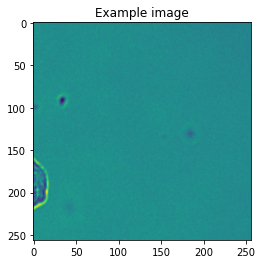

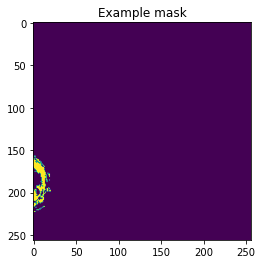

In [25]:
plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(training_imgs[0]))

training_imgs = training_imgs.astype('float32')
training_imgs = training_imgs / training_imgs.max()

training_masks = training_masks.astype('float32')
training_masks = np.where(training_masks > 0.5, 1, 0)

plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(training_masks[0]))

In [34]:
minibatch_dict2, training_imgs2, training_masks2= read_imgs_masks_in_patches(training_img_dir, training_mask_dir, img_rows, img_cols)
minibatch_dict2

{0: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 7.62939453125e-05},
 1: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0111236572265625},
 2: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.00152587890625},
 3: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0760498046875},
 4: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0016326904296875},
 5: {'pad_x1': 60,
  'pad_x2': 60,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 6: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.005706787109375},
 7: {'pad_x1': 30,
  'pad_x2': 31,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 8: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0030670166015625},
 9: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc

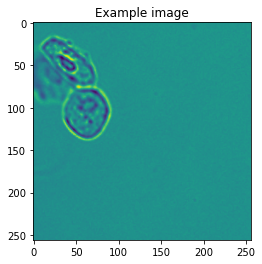

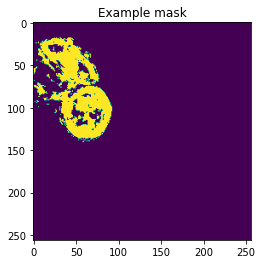

In [36]:
plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(training_imgs2[3]))

training_imgs2 = training_imgs2.astype('float32')
training_imgs2 = training_imgs2 / training_imgs2.max()

training_masks2 = training_masks2.astype('float32')
training_masks2 = np.where(training_masks2 > 0.5, 1, 0)

plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(training_masks2[3]))

In [39]:
#concatenating the two to create a combined set of training images which is a combination of two minibatches
training_imgs_concat = np.concatenate((training_imgs, training_imgs2), axis=0)
print(training_imgs_concat.shape)

training_masks_concat = np.concatenate((training_masks, training_masks2), axis=0)
print(training_masks_concat.shape)

(20, 256, 256, 1)
(20, 256, 256, 1)


In [ ]:
#Percentge of each minibatch that should correspond to foreground object
thresh_obj_perc = 0.25

In [26]:
# load test images

minibatch_dict, test_imgs, test_masks= read_imgs_masks_in_patches(test_img_dir, test_mask_dir, img_rows, img_cols)

In [27]:
minibatch_dict

{0: {'pad_x1': 124,
  'pad_x2': 124,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 1: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 2: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.000518798828125},
 3: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0221405029296875},
 4: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.00457763671875},
 5: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.03997802734375},
 6: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0237274169921875},
 7: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.036529541015625},
 8: {'pad_x1': 37,
  'pad_x2': 38,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 6.103515625e-05},
 9: {'pad_x1': 1,
  'pad_x2': 1,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc

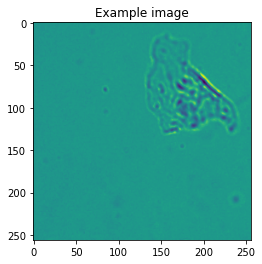

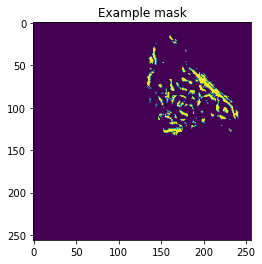

In [28]:
plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(test_imgs[3]))

test_imgs = test_imgs.astype('float32')
test_imgs = test_imgs / test_imgs.max()

test_masks = test_masks.astype('float32')
test_masks = np.where(test_masks > 0.5, 1, 0)

plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(test_masks[3]))

In [17]:
training_imgs.shape

(10, 256, 256, 1)

In [30]:
print(f' The final width is: {training_imgs.shape[1]}'
      f' and height is {training_imgs.shape[2]}'
       '\nNB:if images are not square - correct or rerun')

 The final width is: 256 and height is 256
NB:if images are not square - correct or rerun


In [31]:
# np.savez('../data/full_res_patch_dataset_sample.npz', training_imgs=training_imgs,
#                                  training_masks=training_masks,
#                                  test_imgs=test_imgs,
#                                  test_masks=test_masks)

In [ ]:
#Further considerations:
#Add an alternative stopping criterion for the patch generator - for eg. iterations

#### More in Python generator format

In [7]:
#Percentge of each minibatch that should correspond to foreground object
thresh_obj_perc = 0.25


In [8]:
#Converting above patch generating function into the structure of python generator
def gen_read_imgs_masks_in_patches(img_dir, mask_dir, img_rows, img_cols,
                    target_width=target_width, target_height=target_height,
                    n_minibatches=n_minibatches, minibatch_size=minibatch_size, thresh_obj_perc=thresh_obj_perc,max_iter=10):
    try:
        random.seed(123)
        images = [f for f in os.listdir(img_dir) if f.endswith('.tif')]

        #creating a dictionary for the paths of img and msk and the enumerated number corresponding to it
        img_msk_dict = {}
        for idx, img in enumerate(images):
            img_msk_dict[idx] = [img]
            msk = img.replace('.tif', '_Simple Segmentation.tif')
            img_msk_dict[idx].append(msk)

        #print(img_msk_dict)

        minibatch_dict = {}
        minibatch_c = 0
        trial = 1

        best_thresh_met = 0
        best_minibatch_dict = {}
        best_imgs_minibatch = np.ndarray((minibatch_size, target_height, target_width, 1), dtype=np.float64)
        best_masks_minibatch = np.ndarray((minibatch_size, target_height, target_width, 1), dtype=np.float64)

        while minibatch_c < n_minibatches and trial <= max_iter: # or trial > max_iter = 50
            imgs_minibatch = np.ndarray((minibatch_size, target_height, target_width, 1), dtype=np.float64)
            masks_minibatch = np.ndarray((minibatch_size, target_height, target_width, 1), dtype=np.float64)
            for idx in range(minibatch_size):
                
                #picking a random training image and corresponding from the list
                rand = random.randrange(len(images))
                msk = img_msk_dict[rand][1]
                img = img_msk_dict[rand][0]

                img = imread(os.path.join(img_dir, img), as_gray=True)
                #generating a random patch of img
                rand_x = random.randrange(img.shape[0])
                rand_y = random.randrange(img.shape[1])
                img = img[rand_x : min(rand_x+target_width,img.shape[0]), rand_y : min(rand_y+target_width,img.shape[1])]

                #padding img to fit the network
                pad_x = (target_width - img.shape[0])/2
                pad_y = (target_height - img.shape[1])/2

                if int(pad_x) > pad_x or int(pad_x) < pad_x :
                    if int(pad_y) > pad_y or int(pad_y) < pad_y :
                        pad_x1 = int(np.floor(pad_x))
                        pad_x2 = int(np.ceil(pad_x))
                        pad_y1 = int(np.floor(pad_y))
                        pad_y2 = int(np.ceil(pad_y))
                    else:
                        pad_x1 = int(np.floor(pad_x))
                        pad_x2 = int(np.ceil(pad_x))
                        pad_y1 = int(pad_y)
                        pad_y2 = int(pad_y)

                else:
                    if int(pad_y) > pad_y or int(pad_y) < pad_y :
                        pad_x1 = int(pad_x)
                        pad_x2 = int(pad_x)
                        pad_y1 = int(np.floor(pad_y))
                        pad_y2 = int(np.ceil(pad_y))            
                    else:
                        pad_x1 = int(pad_x)
                        pad_x2 = int(pad_x)
                        pad_y1 = int(pad_y)
                        pad_y2 = int(pad_y)
                    
                img = np.pad(img, ((pad_x1, pad_x2), (pad_y1, pad_y2)),
                                        mode='constant', constant_values=0)    

                img = np.expand_dims(img, axis=-1)
                imgs_minibatch[idx] = img
                
                mask = imread(os.path.join(mask_dir, msk), as_gray=True)
                #generating the corresponding random patch of msk
                mask = mask[rand_x : min(rand_x+target_width,mask.shape[0]), rand_y : min(rand_y+target_width,mask.shape[1])]

                #padding msk same as img to fit the network
                mask = np.pad(mask, ((pad_x1, pad_x2), (pad_y1, pad_y2)),
                                        mode='constant', constant_values=0) 

                mask = np.expand_dims(mask, axis=-1)
                masks_minibatch[idx] = mask
            

                #count perc of white pixels in bw mask
                mask_bw = np.rint(mask)
                number_of_white_pix = np.sum(mask_bw == 255)      # extracting only white pixels 
                perc_of_white_pix = number_of_white_pix/(mask_bw.shape[0]*mask_bw.shape[1])

                minibatch_dict[idx] = {}
                minibatch_dict[idx]['pad_x1'] = pad_x1 #left
                minibatch_dict[idx]['pad_x2'] = pad_x2 #right
                minibatch_dict[idx]['pad_y1'] = pad_y1 #top
                minibatch_dict[idx]['pad_y2'] = pad_y2 #bottom
                minibatch_dict[idx]['perc_of_white_pix'] = perc_of_white_pix
            
            minibatch_white_pix_perc_l = [minibatch_dict[idx]['perc_of_white_pix'] for idx in range(minibatch_size)]
            if np.mean(minibatch_white_pix_perc_l) >= thresh_obj_perc :
                minibatch_c += 1
                best_minibatch_dict = minibatch_dict
                best_imgs_minibatch = imgs_minibatch
                best_masks_minibatch = masks_minibatch
            else:
                if np.mean(minibatch_white_pix_perc_l) > best_thresh_met :
                    best_thresh_met = np.mean(minibatch_white_pix_perc_l)
                    best_minibatch_dict = minibatch_dict
                    best_imgs_minibatch = imgs_minibatch
                    best_masks_minibatch = masks_minibatch

            trial += 1
    except Exception as e:
        print(traceback.format_exc(e))
    finally:
        yield best_minibatch_dict, best_imgs_minibatch, best_masks_minibatch


In [8]:
RandomPatchGenerator = gen_read_imgs_masks_in_patches(img_dir=training_img_dir, mask_dir=training_mask_dir,
                                                         img_rows = img_rows, img_cols= img_cols)

In [9]:
# load training images

minibatch_dict, training_imgs, training_masks=next(RandomPatchGenerator)

In [10]:
minibatch_dict

{0: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 32,
  'pad_y2': 32,
  'perc_of_white_pix': 1.52587890625e-05},
 1: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.00738525390625},
 2: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 3: {'pad_x1': 64,
  'pad_x2': 64,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0137939453125},
 4: {'pad_x1': 57,
  'pad_x2': 58,
  'pad_y1': 8,
  'pad_y2': 8,
  'perc_of_white_pix': 0.0112152099609375},
 5: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.010498046875},
 6: {'pad_x1': 74,
  'pad_x2': 74,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 7: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 8: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 9: {'pad_x1': 46,
  'pad_x2': 46,
  'pad_y1': 108,
  'pad_y2': 108,
  'perc_of_white_pix': 0.0}}

In [11]:
minibatch_white_pix_perc_l = [minibatch_dict[idx]['perc_of_white_pix'] for idx in range(minibatch_size)]
np.mean(minibatch_white_pix_perc_l)

0.004290771484375

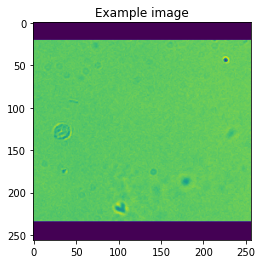

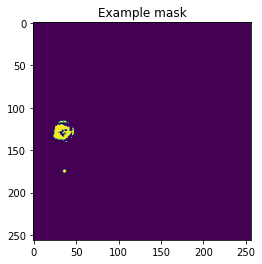

In [12]:
plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(training_imgs[3]))

training_imgs = training_imgs.astype('float32')
training_imgs = training_imgs / training_imgs.max()

training_masks = training_masks.astype('float32')
training_masks = np.where(training_masks > 0.5, 1, 0)

plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(training_masks[3]))

In [13]:
test_RandomPatchGenerator = gen_read_imgs_masks_in_patches(img_dir=test_img_dir, mask_dir=test_mask_dir,
                                                         img_rows = img_rows, img_cols= img_cols)

In [14]:
# load test images

test_minibatch_dict, test_imgs, test_masks= next(test_RandomPatchGenerator)

In [15]:
test_minibatch_dict

{0: {'pad_x1': 84,
  'pad_x2': 85,
  'pad_y1': 19,
  'pad_y2': 19,
  'perc_of_white_pix': 7.62939453125e-05},
 1: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 2: {'pad_x1': 64,
  'pad_x2': 64,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 3: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 4: {'pad_x1': 74,
  'pad_x2': 74,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0},
 5: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.001861572265625},
 6: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0008392333984375},
 7: {'pad_x1': 46,
  'pad_x2': 46,
  'pad_y1': 108,
  'pad_y2': 108,
  'perc_of_white_pix': 0.0},
 8: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.004486083984375},
 9: {'pad_x1': 0,
  'pad_x2': 0,
  'pad_y1': 0,
  'pad_y2': 0,
  'perc_of_white_pix': 0.0026245117187

In [16]:
test_minibatch_white_pix_perc_l = [test_minibatch_dict[idx]['perc_of_white_pix'] for idx in range(minibatch_size)]
np.mean(test_minibatch_white_pix_perc_l)

0.00098876953125

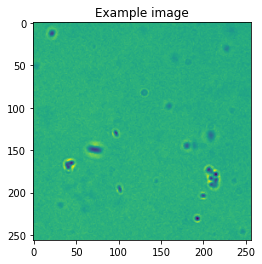

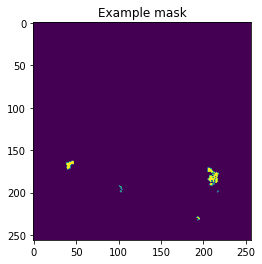

In [19]:
plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(test_imgs[0]))

test_imgs = test_imgs.astype('float32')
test_imgs = test_imgs / test_imgs.max()

test_masks = test_masks.astype('float32')
test_masks = np.where(test_masks > 0.5, 1, 0)

plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(test_masks[0]))

In [20]:
training_imgs.shape

(10, 256, 256, 1)

In [21]:
print(f' The final width is: {training_imgs.shape[1]}'
      f' and height is {training_imgs.shape[2]}'
       '\nNB:if images are not square - correct or rerun')

 The final width is: 256 and height is 256
NB:if images are not square - correct or rerun


In [20]:
# np.savez('../data/gen_full_res_patch_dataset_sample.npz', training_imgs=training_imgs,
#                                  training_masks=training_masks,
#                                  test_imgs=test_imgs,
#                                  test_masks=test_masks)

#### Making individual masks out of multi-instance masks using skimage

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

(1040, 1392)


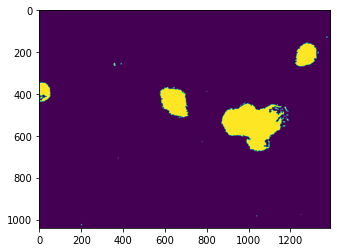

In [10]:
sample_img = imread("../data/samples_n/6776 K 090621_Simple Segmentation-processed.tif", as_gray=True)
print(sample_img.shape)
plt.imshow(sample_img)


(1240, 1592)


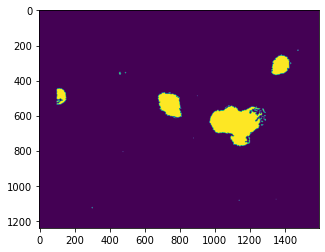

In [11]:
#Patching the image on all 4 sides so that objects at the edge get detected too

pad_n = 100
sample_img_neu = np.pad(sample_img, ((pad_n, pad_n), (pad_n, pad_n)),
                                        mode='constant', constant_values=0)  
print(sample_img_neu.shape)
plt.imshow(sample_img_neu)

(1240, 1592)
(1240, 1592)
(1240, 1592)


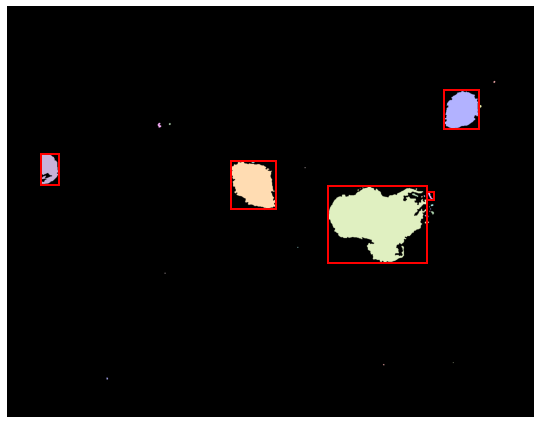

Count of rects: 5


In [32]:
image = np.squeeze(sample_img_neu)
print(image.shape)

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regionss
label_image = label(cleared)
print(image.shape)
print(label_image.shape)

# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

c=0
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        c+=1

ax.set_axis_off()
plt.tight_layout()
plt.show()
print("Count of rects: {}".format(str(c)))

In [13]:
#Function to get the intersection of bboxes returned by regionprops
def get_intersection(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection percentage by taking the intersection
    # area and dividing it by the area of the smaller bbox
    perc_intersection = intersection_area / max(bb1_area , bb2_area)
    assert perc_intersection >= 0.0
    assert perc_intersection <= 1.0
    return perc_intersection

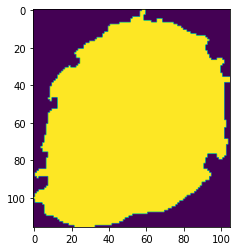

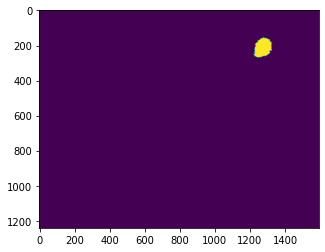

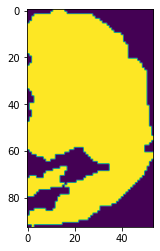

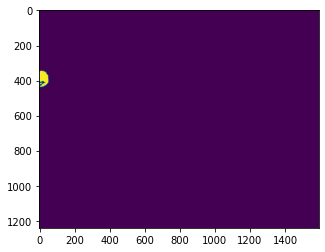

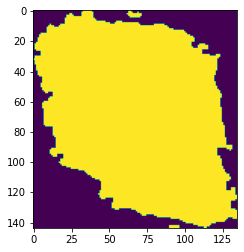

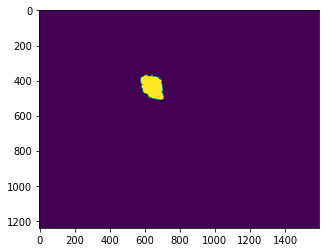

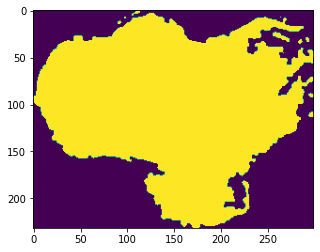

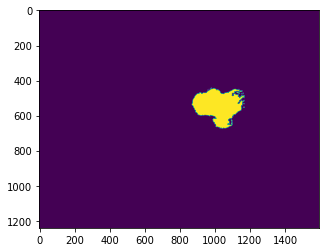

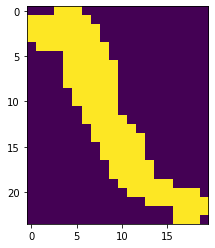

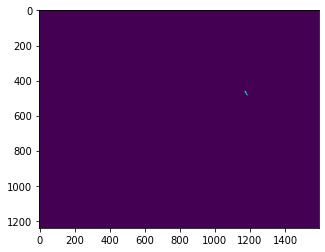

In [23]:
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        plt.figure()
        # draw rectangle around segmented masks
        minr, minc, maxr, maxc = region.bbox

        xt1 = minc
        xt2 = xt1 + (maxc -minc)

        yt1 = minr
        yt2 = yt1 + (maxr -minr)

        # xt1 = max(xt1-10,0)
        # xt2 = min(xt2+10,image.shape[1])

        # yt1 = max(yt1-10,0)
        # yt2 = min(yt2+10,image.shape[0])
        plt.imshow(image[yt1:yt2,xt1:xt2])

        plt.figure()
        background = np.ndarray((image.shape[0],image.shape[1]),dtype=np.float64)
        background[(yt1-pad_n):(yt2-pad_n) , (xt1-pad_n):(xt2-pad_n)] = image[yt1:yt2 , xt1:xt2]
        plt.imshow(background)

#### Downloading files using shared dropbox link

In [18]:
# import dropbox

# dbx = dropbox.Dropbox("{ACCESS TOKEN}")

# folder_shared_link = "https://www.dropbox.com/sh/x60xv12hgyweskv/AAAn4je5EaDyybUytqpKxqPLa?dl=0"
# file_relative_path = "Datasets/Dataset 1 - Split/train"

# res = dbx.sharing_get_shared_link_file_to_file("data/dropbox/test/", 
# url="https://www.dropbox.com/sh/x60xv12hgyweskv/AAAn4je5EaDyybUytqpKxqPLa?dl=0",
# path="/Datasets/Dataset 1 - Split/test/", link_password=None)

# print(res)

#### Removing common files between finetuning and training set sent by UCL

In [22]:
import pandas as pd

finetuning_list_df = pd.read_csv('/bigdata/casus/MLID/DeepUTI/ucl/Finetuning set/finetuning-list dataset1.csv',header=None)
finetuning_list_df.tail(5)

,0
84,8204 L 070721.tif
85,8225 A 130721 2.tif
86,8240 D 210721.tif
87,8245 I 210721.tif
88,8255 G 280721.tif


In [23]:
len(finetuning_list_df[0].unique())

89

In [24]:
import shutil

# original = r'/bigdata/casus/MLID/DeepUTI/ucl/Finetuning set/removed_from_training/'
# target = r'/bigdata/casus/MLID/DeepUTI/ucl/dataset1/removed_from_training/'

# shutil.move(original, target)

In [25]:
# import os

# os.mkdir('/bigdata/casus/MLID/DeepUTI/ucl/dataset1/removed_from_training/img/')
# os.mkdir('/bigdata/casus/MLID/DeepUTI/ucl/dataset1/removed_from_training/mask/')

In [1]:
import glob

files = glob.glob('/bigdata/casus/MLID/DeepUTI/ucl/dataset1/dataset1-img/img/*.tif')
len(set(files))

10000

In [3]:
len(set(glob.glob('/bigdata/casus/MLID/DeepUTI/ucl/dataset1/processed mask/*.tif')))

10000

In [29]:
files_mask = glob.glob('/bigdata/casus/MLID/DeepUTI/ucl/dataset1/dataset1-mask/mask/*.tif')
len(set(files_mask))

10000

In [27]:
def check(filename,file_list):
    check = False
    for f in file_list:
        if(check!=True):
            if filename in f:
                check=True
                
        else:
            break
            
    return check

In [28]:
finetuning_list = list(finetuning_list_df[0])
for f in finetuning_list:
    if check(f,files)==True:
        shutil.move('/bigdata/casus/MLID/DeepUTI/ucl/dataset1/dataset1-img/img/'+f,'/bigdata/casus/MLID/DeepUTI/ucl/dataset1/removed_from_training/img/'+f)
        shutil.move('/bigdata/casus/MLID/DeepUTI/ucl/dataset1/dataset1-mask/mask/'+f[:-4]+'_Simple Segmentation.tif','/bigdata/casus/MLID/DeepUTI/ucl/dataset1/removed_from_training/mask/'+f[:-4]+'_Simple Segmentation.tif')

In [31]:
files_removed_img_list = glob.glob('/bigdata/casus/MLID/DeepUTI/ucl/dataset1/removed_from_training/img/*.tif')
len(files_removed_img_list)

89

In [32]:
files_removed_mask_list = glob.glob('/bigdata/casus/MLID/DeepUTI/ucl/dataset1/removed_from_training/mask/*.tif')
len(files_removed_mask_list)

89

In [33]:
training_files = glob.glob('/bigdata/casus/MLID/DeepUTI/ucl/dataset1/dataset1-img/img/*.tif')
len(set(training_files))

10000

#### Checking which files are uncommon between images and masks in Groundtruth 2

In [7]:
import glob

files = glob.glob('/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/*')
len(set(files))

100

#### Creating new sample dataset for trial of UNet training

In [1]:
import glob
import random
import shutil
import os

# os.mkdir('/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/')
# os.mkdir('/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/img/')
# os.mkdir('/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/img/img/')
# os.mkdir('/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/mask/')
# os.mkdir('/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/mask/preprocessed')
# os.mkdir('/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/mask/preprocessed/img/')



In [5]:
files = glob.glob('/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/*.tif')
print(len(set(files)))

random.shuffle(files)

files = files[:10]
# _ = [shutil.copy(f,'/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/img/img/'+f.split("/")[-1]) for f in files]
# _ = [shutil.copy('/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/mask/preprocessed/img/'+f.replace('.tif','_Simple Segmentation.tif').split("/")[-1],'/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/mask/preprocessed/img/'+f.replace('.tif','_Simple Segmentation.tif').split("/")[-1]) for f in files]
                 

100


#### Checking the percentage of white pixels on average in the Debug Set

In [1]:
import glob

files = glob.glob('/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/mask/preprocessed/img/*.tif')
print(len(set(files)))

10


In [3]:
import cv2
import numpy as np

perc_ls = []
for f in files:
    img = cv2.imread(f)
    print(np.unique(img))
    number_of_white_pix = np.sum(img > 0)  # extracting non-white pixels 
    perc_of_white_pix = number_of_white_pix/(img.shape[0]*img.shape[1])
    perc_ls.append(perc_of_white_pix)
    
print(np.mean(perc_ls))

[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
0.043336372679045096


#### Making patches out of test images to get average performance metric using the previously trained best model

In [1]:
import sys
sys.path.append('../src')
import numpy as np
import unet7

from PIL import Image
import matplotlib.pyplot as plt

from custom_keras_class_v2 import *

In [2]:
from itertools import product


def sequenced_patchified_predict(img,d,model=None):
    #Takes an image and a given size and returns chunks of that image as a list but in an ordered sequence
    w, h = img.size
    # name = 'img'
    # ext = '.png'
    # fig, axarr = plt.subplots(h-h%d+1,w-w%d+1)
    pred = np.zeros(img.size)
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        # out = os.path.join('../data/Practice/logs/Oct-11-2022_13-07', f'{name}_{i}_{j}{ext}')
        pred[j:j+d,i:i+d] = img.crop(box)
    plt.figure()
    plt.imshow(img)
    plt.figure()
    plt.imshow(pred)

In [3]:
def divide_img_blocks(img, n_blocks=(1040%256+1, 1392%256+1)):
    horizontal = np.array_split(img, n_blocks[0])
    splitted_img = [np.array_split(block, n_blocks[1], axis=1) for block in horizontal]
    return np.asarray(splitted_img, dtype=np.ndarray).reshape(n_blocks)

def combine_img_blocks(img_array):
    combined_img = np.array([])
    for i in range(img_array.shape[0]):
        temp = np.array([])
        for j in range(img_array.shape[1]):
            temp = np.hstack([temp,np.squeeze(img_array[i,j])]) if temp.size else np.squeeze(img_array[i,j])
        combined_img = np.vstack([combined_img,temp]) if combined_img.size else temp

    return combined_img

In [4]:
test_image_tf = dict(samplewise_center=True,
                samplewise_std_normalization=True,
                vertical_flip=False,
                horizontal_flip=False,
                preprocessing_function=False,
                fill_mode=True,
                max_iter = False,
                thresh_obj_perc = False,
                target_width = False,
                target_height = False
                    
                )
test_mask_tf = dict(samplewise_center=False,
                samplewise_std_normalization=False,
                vertical_flip=False,
                horizontal_flip=False,
                preprocessing_function=True,
                fill_mode=True,
                max_iter = False,
                thresh_obj_perc = False,
                target_width = False,
                target_height = False
                    
                )

img_mask_args_avg_test_per = dict(samplewise_center=True,
                    samplewise_std_normalization=True,
                    vertical_flip=False,
                    horizontal_flip=False,
                    preprocessing_function=np.rint,
                    fill_mode='nearest',
                    max_iter = None,
                    thresh_obj_perc = 0.99,
                    target_width = 1392,
                    target_height = 1040,
                    image_aug_check = test_image_tf,
                    mask_aug_check = test_mask_tf
                     )

image_mask_datagen_avg_test_per = customImageDataGenerator(**img_mask_args_avg_test_per)


In [5]:
# Code to get patches of all the test images and then calculate the average 
#dice coeff between them and their predicted counterparts
import glob

#test_imgs/masks_path without '/' at the end
def average_performance(test_imgs_path,test_masks_path,model): #log_dir 
    dice_coeff_ls = []
    for f in glob.glob(test_imgs_path+'/*.tif'):
        img_path = f
        msk_path = test_masks_path+'/'+f.split('/')[-1].replace('.tif','_Simple Segmentation.tif')

        
            
        img = load_img(
                img_path,
                color_mode="grayscale",
                target_size=(1040,1392),
                interpolation="nearest",
                keep_aspect_ratio=True,
            )
        mask = load_img(
                msk_path,
                color_mode="grayscale",
                target_size=(1040,1392),
                interpolation="nearest",
                keep_aspect_ratio=True,
                )
        # print('objects read')
        x = img_to_array(img, data_format='channels_last')
        y = img_to_array(mask, data_format='channels_last')
        # Pillow images should be closed after `load_img`,
        # but not PIL images.
        if hasattr(img, "close"):
            img.close()
        if hasattr(mask, "close"):
            mask.close() 

        x = image_mask_datagen_avg_test_per.standardize(x,test_image_tf)
        y = image_mask_datagen_avg_test_per.standardize(y,test_mask_tf)
        # print('standardized')
        
        # print(x.shape)
        # print(y.shape)
        
        x_padded = np.pad(np.squeeze(x), ((0, ((1040//256+1)*256)-1040), (0, ((1392//256+1)*256)-1392)),
                            mode='constant', constant_values=0)
        # print(x_padded.shape)
        
        img_array = divide_img_blocks(np.expand_dims(x_padded,axis=-1), n_blocks=(1280//256, 1536//256))
        
        # print(img_array.shape)
        pred_array = np.empty_like(img_array)
        for i in range(img_array.shape[0]):
            for j in range(img_array.shape[1]): 
                pred_array[i,j] = model.predict(tf.convert_to_tensor(img_array[i,j][np.newaxis],tf.float32))
                
        pred = combine_img_blocks(pred_array)
        # recombined_img  = combine_img_blocks(img_array)
        
        pred = np.float32(pred[:1040,:1392])
        pred = (pred - pred.min()) / (pred.max() - pred.min())
        y = (y - y.min()) / (y.max() - y.min())
        
        if "130 V 261021_Simple Segmentation.tif" in msk_path:
            continue
            
            plt.figure(figsize=(40,8))
            plt.subplot(1, 3, 1)
            plt.title('Input')
            plt.imshow(np.squeeze(x))

            plt.subplot(1, 3, 2)
            plt.title('Prediction')
            plt.imshow(np.squeeze(pred))

            plt.subplot(1, 3, 3)
            plt.title('Ground truth')
            plt.imshow(np.squeeze(y))

            plt.savefig(os.path.join(log_dir,'sample_ground_truth_{}.svg'.format('test')), bbox_inches='tight', dpi=300)
            plt.savefig(os.path.join(log_dir,'sample_ground_truth_{}.png'.format('test')), bbox_inches='tight', dpi=300)
            plt.show()
            break
            
        # print(pred.shape)
        # print(pred.dtype)
        # print(y.shape)
        # print(y.dtype)
        # print('patchified')
        dice_coeff_ls.append(unet7.dice_coeff(np.squeeze(y),pred))
        # break
        print(f)
    
    return np.mean(dice_coeff_ls)

In [ ]:
average_performance(test_imgs_path='/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img',
                   test_masks_path='/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/mask/preprocessed/img',model)

#### Checking for significant differences between the training and the test set

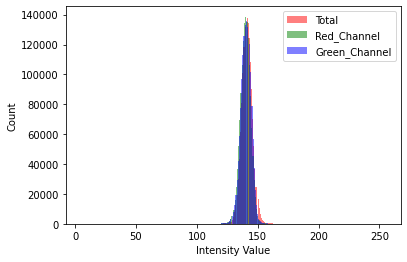

In [1]:
import os
import random
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2


arr_r = []
arr_g = []
arr_b = []

train_dir = '/bigdata/casus/MLID/DeepUTI/ucl/dataset1/dataset1-img/img/'
val_dir = '/bigdata/casus/MLID/DeepUTI/ucl/Validation set/img/img/'

val_files = os.listdir(val_dir)
choice_indices = np.random.choice(range(len(val_files)), size=20, replace=True)
choice_indices = list(choice_indices)
random10_files = [val_files[a] for a in choice_indices]

for f in random10_files:  
    if f.endswith('.tif'):
        # print(f)
        x = cv2.imread(val_dir+f)
        arr_r.append(list(x[:, :, 0].ravel()))
        arr_g.append(list(x[:, :, 1].ravel()))
        arr_b.append(list(x[:, :, 2].ravel()))

fig = plt.figure()
val_r = plt.hist(arr_r[0], bins = 256, color = 'red', alpha = 0.5)
val_g = plt.hist(arr_g[0], bins = 256, color = 'Green', alpha = 0.5)
val_b = plt.hist(arr_b[0], bins = 256, color = 'Blue', alpha = 0.5)
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

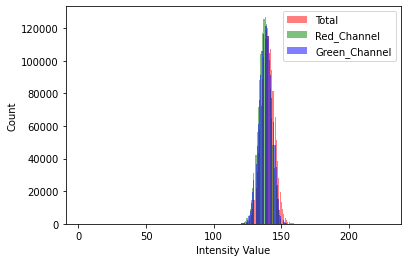

In [2]:
train_files = os.listdir(train_dir)
choice_indices = np.random.choice(range(len(train_files)), size=20, replace=True)
choice_indices = list(choice_indices)
random10_files = [train_files[a] for a in choice_indices]

arr_r = []
arr_g = []
arr_b = []

for f in random10_files:  
    if f.endswith('.tif'):
        # print(f)
        x = cv2.imread(train_dir+f)
        arr_r.append(list(x[:, :, 0].ravel()))
        arr_g.append(list(x[:, :, 1].ravel()))
        arr_b.append(list(x[:, :, 2].ravel()))

fig = plt.figure()
train_r = plt.hist(arr_r[0], bins = 256, color = 'red', alpha = 0.5)
train_g = plt.hist(arr_g[0], bins = 256, color = 'Green', alpha = 0.5)
train_b = plt.hist(arr_b[0], bins = 256, color = 'Blue', alpha = 0.5)
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

In [3]:
## Quantifying difference between the above histograms above 
# import the necessary packages
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

#1. Take 10 random images for each set
#2. Calculate their histograms and compare
#3. Take average matching between thems

train_dir = '/bigdata/casus/MLID/DeepUTI/ucl/dataset1/dataset1-img/img/'
val_dir = '/bigdata/casus/MLID/DeepUTI/ucl/Validation set/img/img/'

val_files = os.listdir(val_dir)
choice_indices = np.random.choice(range(len(val_files)), size=20, replace=True)
choice_indices = list(choice_indices)
val_random10_files = [val_files[a] for a in choice_indices]

train_files = os.listdir(train_dir)
choice_indices = np.random.choice(range(len(train_files)), size=20, replace=True)
choice_indices = list(choice_indices)
train_random10_files = [train_files[a] for a in choice_indices]

index_train = {}
index_val = {}
images_train = {}
images_val = {}

for (f_val, f_train) in list(zip(val_random10_files,train_random10_files)):
    if f_val.endswith('.tif') and f_train.endswith('.tif'):
        train_image = cv2.imread(train_dir+f_train)
        val_image = cv2.imread(val_dir+f_val)
    images_val[f_val] = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
    images_train[f_train] = cv2.cvtColor(val_image, cv2.COLOR_BGR2RGB)                          
    # extract a 3D RGB color histogram from the image,
    # using 256 [0-255] bins per channel, normalize, and update
    # the index
    hist1 = cv2.calcHist([train_image], [0, 1, 2], None, [256, 256, 256],[0, 256, 0, 256, 0, 256])
    hist2 = cv2.calcHist([val_image], [0, 1, 2], None, [256, 256, 256],[0, 256, 0, 256, 0, 256])

    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()
    index_train[f_train] = hist1
    index_val[f_val] = hist2
    
OPENCV_METHODS = (("Correlation", cv2.HISTCMP_CORREL),("Chi-Squared", cv2.HISTCMP_CHISQR),
                  ("Intersection", cv2.HISTCMP_INTERSECT),("Bhattacharyya", cv2.HISTCMP_BHATTACHARYYA))

# loop over the comparison methods
for (methodName, method) in OPENCV_METHODS:
    # initialize the results dictionary and the sort
    # direction
    reverse = False
    # if we are using the correlation or intersection
    # method, then sort the results in reverse order
    if methodName in ("Correlation", "Intersection"):
        reverse = True

    value_list = []
    # loop over the index
    for (hist1, hist2) in list(zip(list(index_train.values()),list(index_val.values()))):
        # compute the distance between the two histograms
        # using the method and update the results dictionary
        d = cv2.compareHist(hist1, hist2, method)
        value_list.append(d)
    print("Method:",methodName)
    print("Value:",np.mean(d))

Method: Correlation
Value: 0.8409660825770374
Method: Chi-Squared
Value: 46.263074040251254
Method: Intersection
Value: 32.861752741839155
Method: Bhattacharyya
Value: 0.3120294401625629


#### Making validation set static

In [ ]:
import tensorflow as tf

cifar = tf.keras.datasets.cifar100
(x_train, y_train), (x_test, y_test) = cifar.load_data()

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [ ]:
model.fit(datagen.flow(x_train, y_train, batch_size=32,
             subset='training'),
             validation_data=datagen.flow(x_train, y_train,
             batch_size=8, subset='validation'),
             steps_per_epoch=len(x_train) / 32, epochs=epochs)

### ROUGH WORK

In [20]:
files_mask[0][:-4]

'/bigdata/casus/MLID/DeepUTI/ucl/dataset1/dataset1-mask/mask/6809 G 070421_Simple Segmentation'

In [ ]:
images = [f for f in os.listdir(training_img_dir) if f.endswith('.tif')]
masks = [f for f in os.listdir(training_mask_dir) if f.endswith('.tif')]
img = imread(os.path.join(training_img_dir, images[0]), as_gray=True)
msk = imread(os.path.join(training_mask_dir, masks[0]), as_gray=True)
print(img.shape)
print(msk.shape)

In [6]:
import numpy as np
ls1 = ['a','b','c','d','e']
ls2 = ['a1','b1','c1','d1','e1']


choice_indices = np.random.choice(range(len(ls1)), size=10, replace=True)
choice_indices = list(choice_indices)
ls1, ls2 = [ls1[a] for a in choice_indices],[ls2[a] for a in choice_indices]

print(ls1)
print(ls2)

['e', 'e', 'a', 'a', 'd', 'c', 'c', 'a', 'a', 'c']
['e1', 'e1', 'a1', 'a1', 'd1', 'c1', 'c1', 'a1', 'a1', 'c1']
